# HR Analytics - Predicting Employee Turnover


- With the evolution of Data Science, HR Analytics is having a significant impact on the HR policies of various organizations.

- It is very important that companies recognize and understand what factors are associated with employee turnover. This will allow pro-active action and limit employee attrition at various firms.

- Predictive analytics give managers the opportunity to take corrective steps to build and preserve their successful business.

















## Goal
_The goal is to understand what factors contribute most to employee turnover and create a model that can predict if a certain employee will leave the company or not._

# 3. Key Findings
- There is 16.60% Employee attrition at the firm

- Attrition rate is maximum for employees with 5 years of experience at the firm

- Employees with 3 to 5 years of experience reported lower satisfaction levels on average

- As expected, attrition rate is high for employees with low salaries

- We note that there are 3 clusters of employees leaving the firm:
    - Top rated, Less satisfaction
    - Top rated, Highly satisfaction
    - Bottom rated, below average satisfaction
- 54% of the employees who left the firm worked more than the average monthly hours (200 hours)
- Attrition rate is high for employees in the under-worked and over-worked segment
     - Employees left when they are underworked (less than 150hr/month or 5hr/day)
     - Employees left when they are overworked (more than 250hr/month or 10hr/day)
     
4. Approach
 - Load the required libraries

 - Load the dataset
 
 - Overview of the dataset

 - Data Manipulation
 
 - Exploratory Data Analysis

 - Data Pre-Processing

 - Model Selection

 - Recursive Feature Elimination

 - Select Features

 - Model Tuning - Hyperparameter optimization

 - Final Model

 - Evaluate Final Model

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.chdir(r"C:\Users\Dan Masibo\Documents\Python Projects\hr_project")

In [3]:
hr=pd.read_csv('HR_Dataset.csv')

In [4]:
hr.columns.tolist()

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'Departments ',
 'salary']

In [5]:
os.getcwd()

'C:\\Users\\Dan Masibo\\Documents\\Python Projects\\hr_project'

### 5. Load the required libraries

In [6]:
#suppress warnings

import warnings
warnings.filterwarnings('ignore')

In [7]:
#!pip install pandas_profiling 

In [8]:
#!pip install missingno

In [9]:
#import required modules
#from pandas_profiling import ProfileReport
import missingno as msno

In [10]:
#!pip install imblearn

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Pre-Processing libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline

#Sk-Learn Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Sk-Learn Model Selection
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from scipy import stats

In [12]:
#Set Seaborn Theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_style("darkgrid")

In [13]:
#Setting to display Pipeline
from sklearn import set_config
set_config(display="diagram")

### Load the DataSet

In [14]:
import os
os.chdir(r"C:\Users\Dan Masibo\Documents\Python Projects\hr_project")

In [15]:
import pandas as pd
hr=pd.read_csv('HR_Dataset.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 7. Overview of the dataset

#### 7.1 Check for missing values

In [16]:
hr.isna().mean()*100

satisfaction_level       0.0
last_evaluation          0.0
number_project           0.0
average_montly_hours     0.0
time_spend_company       0.0
Work_accident            0.0
left                     0.0
promotion_last_5years    0.0
Departments              0.0
salary                   0.0
dtype: float64

<AxesSubplot:>

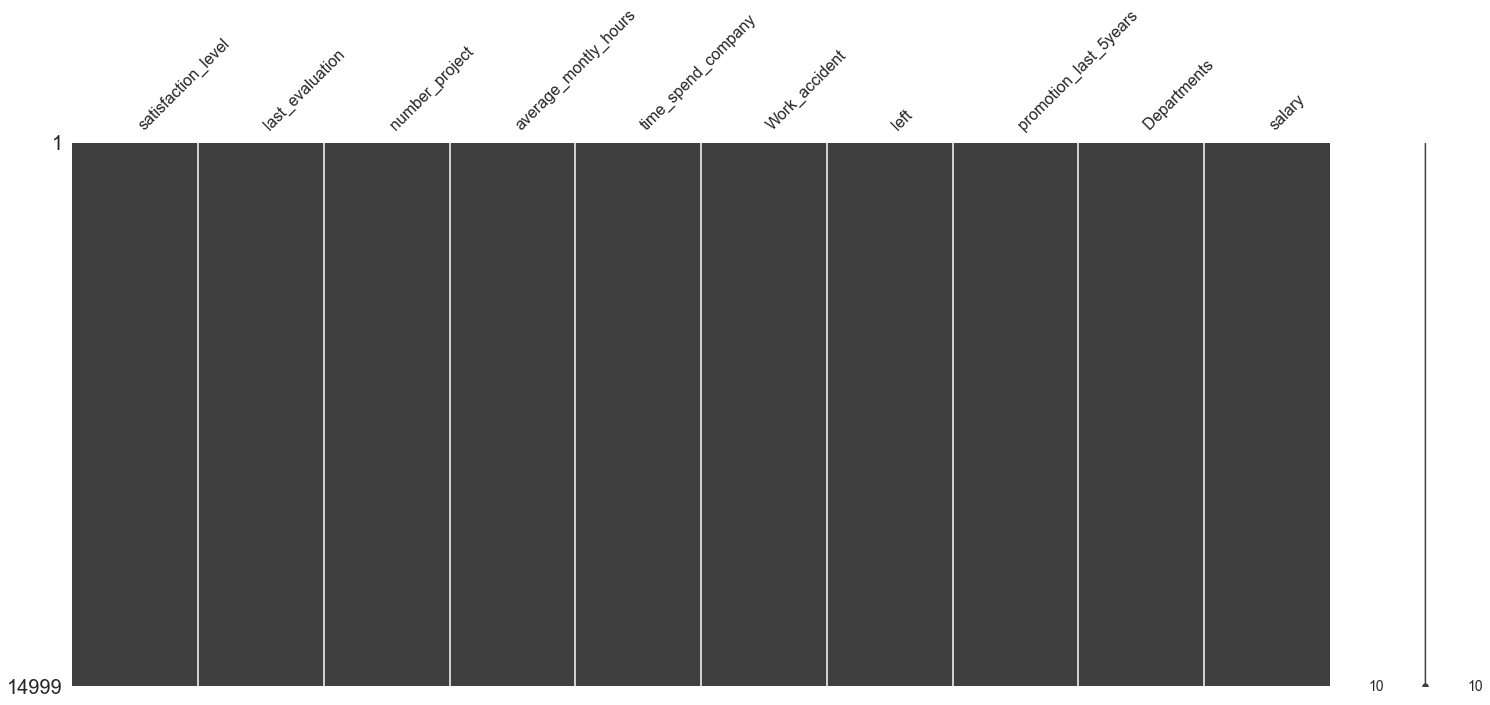

In [17]:
# Visualize missing values as a matrix
msno.matrix(hr)

<AxesSubplot:>

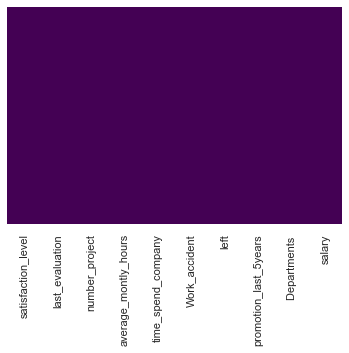

In [18]:
sns.heatmap(hr.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## 8. Data manipulation

#### 8.1 Rename columns

In [19]:
# Renaming columns with a better description
hr=hr.rename(columns={'satisfaction_level':'satisfaction',
                     'last_evaluation':'evaluation',
                     'number_project':'projectCount',
                     'average_montly_hours':'averageMonthlyHours',
                     'time_spend_company':'yearsAtCompany',
                     'Work_accident':'workAccident',
                     'salary':'salary',
                     'promotion_last_5years':'promotion',
                     'Departments ':'department',
                    'left':'turnover'})

#### 8.2 Move target variable to the beginning of the dataset

In [20]:
front = hr['turnover']
hr.drop(labels=['turnover'], axis=1,inplace = True)
hr.insert(0, 'turnover', front)
hr.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


#### 8.3 Check and remove duplicates

In [21]:
print(hr.duplicated().sum())

3008


In [22]:
# Remove duplocates
hr.drop_duplicates(inplace=True)

In [23]:
print(hr.duplicated().sum())

0


In [24]:
hr.shape[0]

11991

## 9. Exploratory Data Analysis

- Let's explore the dataset and try to find some insights in the dataset. Some initial questions that can be explored

 - Turnover percentage across the firm

 - Employee Attrition by years at company

#### 9.1 Employee Attrition

In [25]:
'{:.2%}'.format(hr['turnover'].sum()/hr['turnover'].count())

'16.60%'

Key Findings

There is a **16.60% employee attrition** at the firm

9.2 -> Attrition rate is maximum for employees with 5 years of experience at the firm

### Key Findings
 - We see that maximum attrition is when employees have spent 5 years with the firm.

 - Another interesting thing to note is that attrition rises gradually from 2 years duration and peaks at 5 years.

 - Attrition falls sharply after an employee has spent more than 5 years with the firm

May be its the case that there is some retention bonus paid at 5 years employment and few employees leave immediately after taking the the bonus. Some wil seeking experience to go work elsewhere owing to the conditions that prevail at the firm.

Or it could also be the case that the retention bonus is conditional. Employees who don't get the bonus leave and those who get the bonus continue to stay with the firm.

In [26]:
#Calculate attrition rate by number of years spent at the firm
attritionRate=hr.groupby('yearsAtCompany')['turnover'].sum()/hr.groupby('yearsAtCompany')['turnover'].count()
attritionRate

yearsAtCompany
2     0.010653
3     0.168401
4     0.246883
5     0.453861
6     0.201107
7     0.000000
8     0.000000
10    0.000000
Name: turnover, dtype: float64

<AxesSubplot:xlabel='yearsAtCompany', ylabel='turnover'>

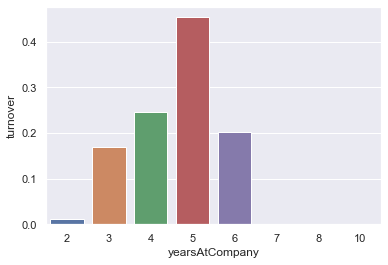

In [27]:
sns.barplot(x=attritionRate.index, y=attritionRate)

9.3 -> Employees with 3 to 5 years of experience reported lower satisfaction levels on average

### Key findings

 - Average satisfaction levels dip for employees during 2 - 4 years stay at the firm

 - Low satisfaction levels could be the reason for higher attrition rate in the employees with 2 - 5 years of stay bracket.

 - Attrition distribution is tri-modal for employee satisfaction levels.
    - Certain Employees with low satisfaction
    - Majority of the Employees with medium satisfaction
    - Certain Employees with high satisfaction

#### Key takeaways for the HR Department

- Why average satisfaction levels are low for employees in the 2-4 years range?

- Could low satisfaction levels be the reason for high attrition in the 2-4 years range?

- Why are employees with high satisfaction leaving the job? (May be better salary?

In [28]:
#Average satisfaction levels by years spent at the firm

avgSatisfactionLevels=hr.groupby('yearsAtCompany')['satisfaction'].mean()
avgSatisfactionLevels

yearsAtCompany
2     0.699165
3     0.648988
4     0.516090
5     0.583183
6     0.571107
7     0.635957
8     0.665062
10    0.655327
Name: satisfaction, dtype: float64

<AxesSubplot:xlabel='yearsAtCompany', ylabel='satisfaction'>

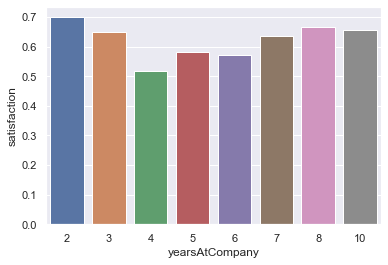

In [29]:
sns.barplot(x=avgSatisfactionLevels.index, y=avgSatisfactionLevels)

In [30]:
#Create a Dataframe to visualize the trend between Emp Satisfaction levels and attrition rate

temphr=pd.DataFrame({'avgSatisfactionLevels':avgSatisfactionLevels, 'attritionRate':attritionRate })
temphr

,avgSatisfactionLevels,attritionRate
yearsAtCompany,,
2,0.699165,0.010653
3,0.648988,0.168401
4,0.516090,0.246883
5,0.583183,0.453861
6,0.571107,0.201107
7,0.635957,0.000000
8,0.665062,0.000000
10,0.655327,0.000000


<AxesSubplot:xlabel='yearsAtCompany'>

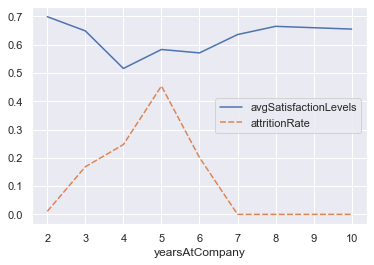

In [31]:
#View attrition rate and average satisfaction levels by years spent at the firm
sns.lineplot(data=temphr)

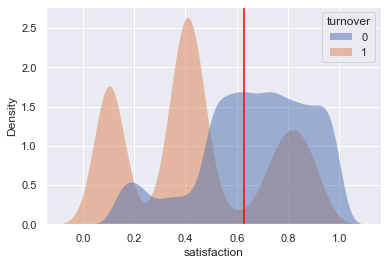

In [32]:
sns.kdeplot(data=hr, x="satisfaction", hue="turnover", fill=True, common_norm=False,
   alpha=.5, linewidth=0)
plt.axvline(x=hr.satisfaction.mean(),
            color='red')

9.4 -> As expected, attrition rate is high for employees with low salaries 

#### Key findings

- Nearly 20% attrition rate in employees with low salaries

- Certain high salaries staff is also leaving the company

Key takeaways for the HR Department:

 - Benchmark salaries of low salaries staff to check whether salary can be improved for certain staff

 - Why are certain high salaried employees leaving the firm?

In [33]:
#Calculate attrition Rate by salary

attritionRateBySalary=hr.groupby('salary')['turnover'].sum()/hr.groupby('salary')['turnover'].count()
attritionRateBySalary

salary
high      0.048485
low       0.204530
medium    0.146170
Name: turnover, dtype: float64

<AxesSubplot:xlabel='salary', ylabel='turnover'>

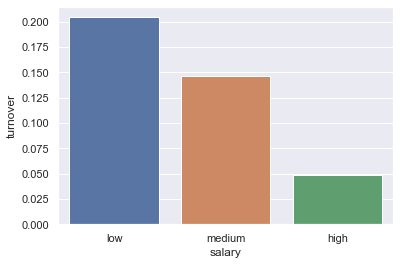

In [34]:
#Plot attrition rate by salary

sns.barplot(x=attritionRateBySalary.index, y=attritionRateBySalary, order=['low', 'medium','high'])

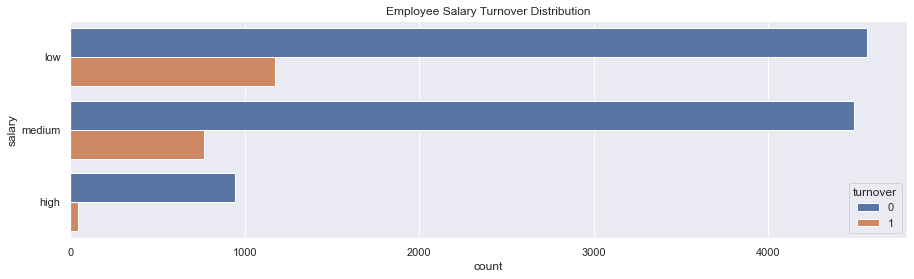

In [35]:
f, ax=plt.subplots(figsize=(15, 4))
sns.countplot(y='salary', hue='turnover', data=hr).set_title('Employee Salary Turnover Distribution');

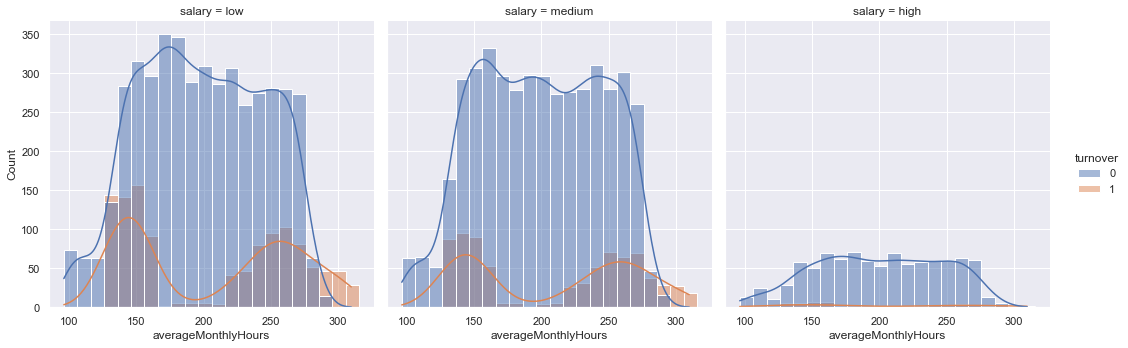

In [36]:
sns.displot(data=hr, x='averageMonthlyHours', binwidth=10, kde=True, hue='turnover', col='salary')

9.5 -> We note that there are 3 clusters of employees leaving the firm

 - Top rated, Less satisfaction
 - Top rated, Highly satisfaction
 - Bottom rated, below average satisfaction

Key takeaways for the HR Department:


 - Why were certain Top rated employees not satisfied with the firm?

    - Were they overworked?
    - Were they not satisfied with their job?
    - Was salary an issue?
 
 - Why are Top Rated and Highly satisfied employees leaving the firm?

    - Are they looking for better opportunities?
    - Is salary or growth an issue for these set of employees?
    - Are they overworked?
 - How can we help underperforming and unsatisfied employees?

    - Can we identify training gaps?
    - Is there some issue with our hiring policy, did we hire people with skills mismatch?

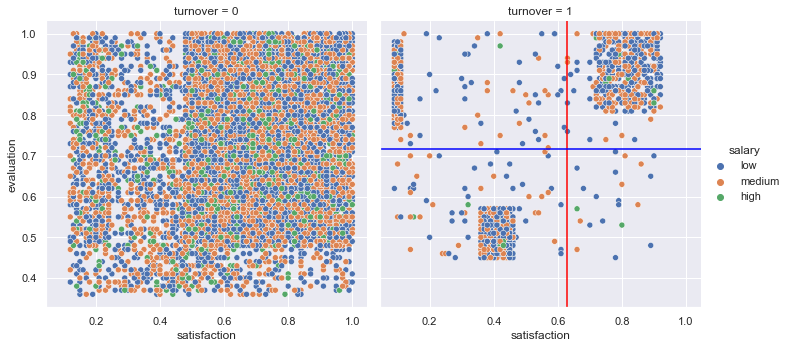

In [37]:
#Visualize scatter plot of satisfaction and evaluation 

#We create this scatterplot to understand how the combination of rating/evaluation effects employee turnover

sns.relplot(x="satisfaction", y="evaluation", col="turnover", hue="salary", data=hr, kind="scatter")
plt.axvline(x=hr.satisfaction.mean(),
            color='red')
plt.axhline(y=hr.evaluation.mean(),
            color='blue')

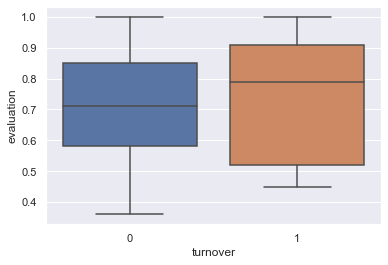

In [38]:
ax=sns.boxplot(x='turnover', y='evaluation', data=hr)

9.6 -> 54% of the employees who left the firm worked more than the average monthly hours (200 hours)

 - Those employees worked hard and were highly satisfied with their job.

Key takeaways for the HR Department

 - Why a group of hard working and highly satisfied employees left their job?

In [39]:
#Average working hours in the firm

hr['averageMonthlyHours'].mean()

200.4735218080227

In [40]:
hr.loc[(hr['turnover']==1) & (hr['averageMonthlyHours']>200), ['turnover']].count()/hr.loc[hr['turnover']==1, ['turnover']].count()

turnover    0.542943
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

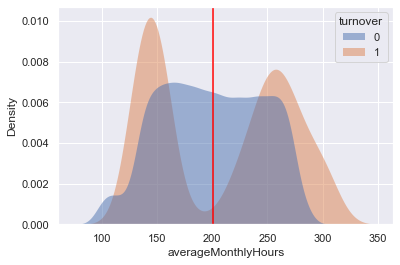

In [41]:
sns.kdeplot(data=hr, x="averageMonthlyHours", hue="turnover", fill=True, common_norm=False,
   alpha=.5, linewidth=0)
plt.axvline(x=hr.averageMonthlyHours.mean(),
            color='red')
plt.show

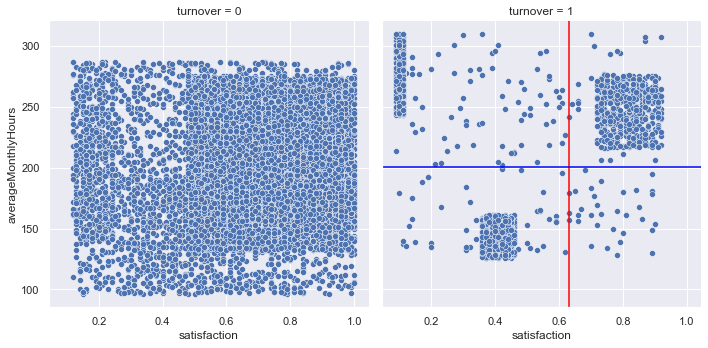

In [42]:
#Visualize scatter plot of satisfaction and evaluation 

#We create this scatterplot to understand how the combination of rating/evaluation effects employee turnover
sns.relplot(x="satisfaction", y="averageMonthlyHours", col="turnover", data=hr, kind="scatter")
plt.axvline(x=hr.satisfaction.mean(),
            color='red')
plt.axhline(y=hr.averageMonthlyHours.mean(),
            color='blue')

9.7 -> Attrition by department

In [43]:
#Calculate average attrition by department
avgAttrition=(hr.groupby('department')['turnover'].sum()/hr.groupby('department')['turnover'].count()).sort_values(ascending=False)
avgAttrition

department
hr             0.188020
accounting     0.175523
technical      0.173797
support        0.171334
sales          0.169805
marketing      0.166419
IT             0.161885
product_mng    0.160350
RandD          0.122478
management     0.119266
Name: turnover, dtype: float64

In [44]:
import seaborn as sns

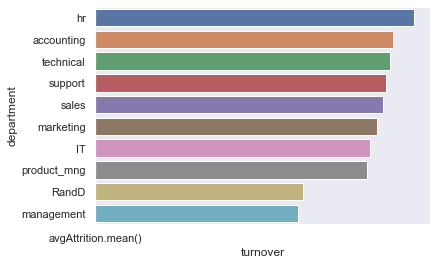

In [45]:
# plot average attrition by department
sns.barplot(y=avgAttrition.index, x=avgAttrition)
plt.axvline(x='avgAttrition.mean()',
            color='red')

In [46]:
# Calculate Average Monthly Hours for each department
avgMonthlyHours=hr.groupby('department')['averageMonthlyHours'].mean()
avgMonthlyHours

department
IT             200.638320
RandD          201.291066
accounting     200.877617
hr             199.371048
management     201.529817
marketing      199.487370
product_mng    198.893586
sales          200.242050
support        200.627128
technical      201.115419
Name: averageMonthlyHours, dtype: float64

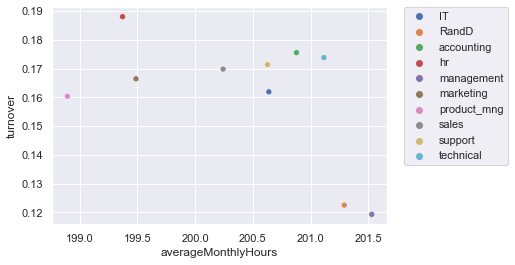

In [47]:
# Create scatterplot for avgMonthlyHours and avgAttrition
sns.scatterplot(x=avgMonthlyHours, y=avgAttrition, hue=avgMonthlyHours.index)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [48]:
from scipy.stats import pearsonr
#calculate correlation coefficient btn avgMonthlyHours and turnover
corr, _=pearsonr(avgMonthlyHours, avgAttrition)
print('correlation coefficient: %.3f' % corr)


correlation coefficient: -0.111


From Pearson Correlation coefficient of **-0.111**, we note that there is not a significant correlation between working long hours and attrition rate

In [49]:
temp=hr.loc[hr['turnover']==1, :].groupby('department')['averageMonthlyHours', 'satisfaction'].mean()
temp

,averageMonthlyHours,satisfaction
department,,
IT,209.537975,0.417089
RandD,212.741176,0.433529
accounting,209.541284,0.414679
hr,197.053097,0.422478
management,207.615385,0.435962
marketing,202.142857,0.454375
product_mng,205.972727,0.467909
sales,206.270909,0.450400
support,208.102564,0.451506


<AxesSubplot:xlabel='averageMonthlyHours', ylabel='satisfaction'>

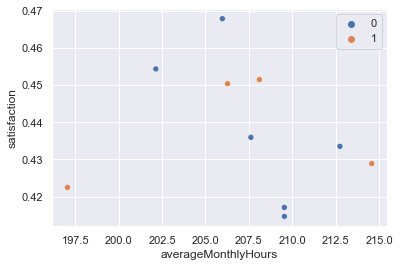

In [50]:
sns.scatterplot(x=temp['averageMonthlyHours'], y=temp['satisfaction'], hue=[0,0,0,1,0,0,0,1,1,1])

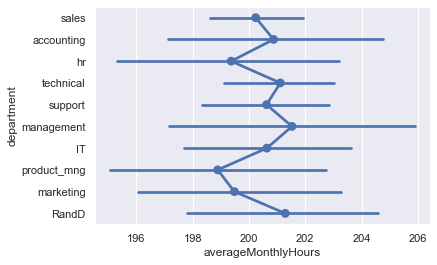

In [51]:
#Distribution pf average working hours per department
ax=sns.pointplot(y='department', x='averageMonthlyHours', data=hr)

We note that there is no specific department which is overburdened and working very long hours

9.8 -> Attrition rate is high for employees in the under-worked and over-worked segment

Key takeaways for the HR Department
 - How can the workload be balance across employees?

<AxesSubplot:xlabel='projectCount', ylabel='Density'>

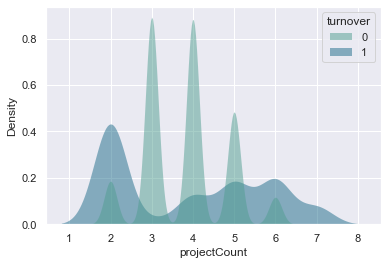

In [52]:
sns.kdeplot(
   data=hr, x="projectCount", hue="turnover",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)

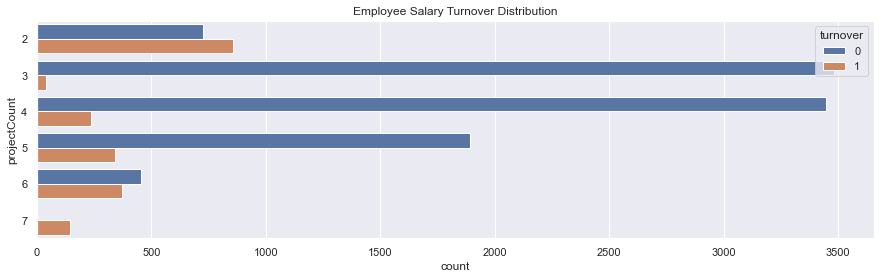

In [53]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="projectCount", hue='turnover', data=hr).set_title('Employee Salary Turnover Distribution');

## 10. Data Pre-Processing (Dummy variables, Test-Train split and Feature Scaling)

### 10.1 Create train-test split

In [54]:
train, test=train_test_split(hr, test_size=0.2, random_state=123, stratify=hr['turnover'])
print(train.shape)
print(test.shape)

(9592, 10)
(2399, 10)


### 10.2 Custom Pre-Processing Transformers

In [55]:
catCols=[col for col in hr.columns if hr[col].dtype=='O']
catCols

['department', 'salary']

In [57]:
numCols=[col for col in hr.columns if hr[col].dtype !='O']
numCols

['turnover',
 'satisfaction',
 'evaluation',
 'projectCount',
 'averageMonthlyHours',
 'yearsAtCompany',
 'workAccident',
 'promotion']

In [58]:
#Custom Transformer that transforms Categorical columns
class DummyEncoding( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, catCols):
        self.catcols = catCols
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        #One-Hot Encoding of categorical columns
        #Get dummy variables
        for each_col in self.catCols:
            X[each_col] = pd.factorize(X[each_col])[0]
        
        return X

In [59]:
#Custom Transformer that scales Numerical columns
class CustomScaler( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, numCols):
        self.numCols = numCols
        self.scaler = MinMaxScaler()
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        self.scaler.fit(X[numCols])
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        X[numCols] = self.scaler.transform(X[numCols])
        
        return X

### 10.3 Pre-Processing pipeline

In [60]:
#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [('dummyEncodingTransformer', DummyEncoding(catCols))] )

In [61]:
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'min_max_scaler', CustomScaler(numCols)) ] )

In [62]:
#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
preProcessingPipeline = Pipeline( steps = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )